In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#download mnist data and split into train and test sets
df = pd.read_csv('FinalData.csv')

In [2]:
X = df.drop(['Label'], axis = 1).values
Y = df['Label']

X = StandardScaler().fit_transform(X)

Xnew = []
for i in range(0, len(X), 250):
    Xnew.append(X[i:250+i])
    
Ynew = []
for j in range(0, 934750, 250):
    Ynew.append(0)
    
for k in range(0, 971750, 250):
    Ynew.append(1)
    
from itertools import groupby
print([len(list(group)) for key, group in groupby(Y)])

Xnew = np.array(Xnew)
print(Xnew[0].shape)
print(Xnew.shape)
#X = StandardScaler().fit_transform(Xnew)

X_train, X_test, y_train, y_test = train_test_split(Xnew, Ynew, test_size = 0.30, random_state = 101)

[934750, 971750]
(250, 128)
(7626, 250, 128)


In [3]:
X_train.shape

(5338, 250, 128)

In [4]:
#reshape data to fit model
X_train = X_train.reshape(5338,250,128,1)
X_test = X_test.reshape(2288,250,128,1)

In [5]:
X_train[0]
X_test.shape

(2288, 250, 128, 1)

In [6]:
# import tensorflow as tf

# tf.__version__

In [7]:
from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

C:\Apps\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([1., 0.], dtype=float32)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.regularizers import l2
import keras
import tensorflow as tf
#create model

keras.regularizers.l1(0.01)
keras.regularizers.l2(0.01)
keras.regularizers.l1_l2(l1=0.01, l2=0.01)

model = Sequential()
#add model layers 
model.add(Conv2D(64, (5,5), activation='relu',
                 input_shape=(250,128,1),padding='SAME'))
model.add(Conv2D(32, (5,5), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                 activation='relu',padding='SAME'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
#model.add(Activation('softmax'))
model.add(Activation(tf.nn.softmax))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10, verbose=0)
print(history)

# print(model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=10, verbose=0))

Instructions for updating:
Use tf.cast instead.


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


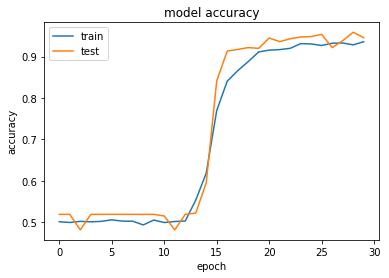

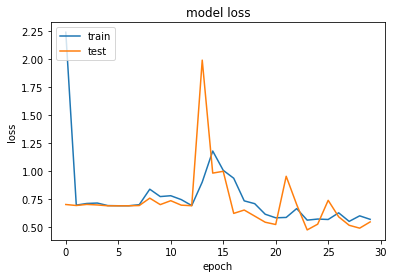

In [11]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
#predict first 4 images in the test set
model.predict(X_test[:4])

array([[1.8447521e-03, 9.9815518e-01],
       [9.9975938e-01, 2.4063760e-04],
       [6.6084566e-04, 9.9933916e-01],
       [8.6878884e-01, 1.3121122e-01]], dtype=float32)

In [13]:
#actual results for first 4 images in test set
y_test[:4]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

[0.5494350891013245, 0.9458041958041958]


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 128, 64)      1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 128, 32)      51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 64, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 64, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32768128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

array([[1001,  100],
       [  24, 1163]], dtype=int64)

In [17]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test[:,0], y_pred_keras[:,0])

#.ravel()

In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_auc_score(y_test, model.predict(X_test))

0.9900901914243542

In [19]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

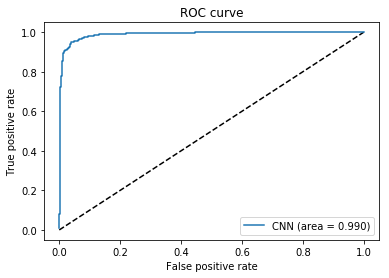

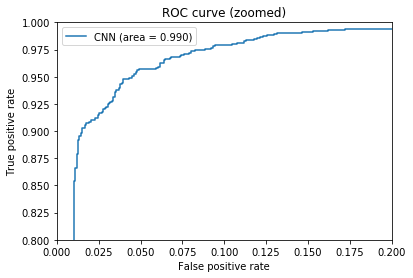

In [20]:
# https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()

In [21]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [23]:
# # later...

from keras.models import model_from_json

# # load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# # evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print(score)

Loaded model from disk
[0.5494350349152839, 0.9458041958041958]
